# Recommendation System for Beer Advocate

In [198]:
import os
import urllib.request

import pandas as pd
import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

In [199]:
file_path = 'https://www.dropbox.com/s/dzg4j2jolmpc8tb/beer_reviews.csv?dl=1'

data = pd.read_csv(file_path)

In [200]:
# Make a copy
df = data[:]

df.head()

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969
4,1075,Caldera Brewing Company,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883


In [201]:
print(f'unique beer styles: {len(df.beer_style.unique())}')
print(f'unique beers: {len(df.beer_beerid.unique())}')
print(f'unique breweries: {len(df.brewery_id.unique())}')
print(f'unique users: {len(df.review_profilename.unique())}')

unique beer styles: 104
unique beers: 66055
unique breweries: 5840
unique users: 33388


## Data Pre-processing

In [202]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1586614 entries, 0 to 1586613
Data columns (total 13 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   brewery_id          1586614 non-null  int64  
 1   brewery_name        1586599 non-null  object 
 2   review_time         1586614 non-null  int64  
 3   review_overall      1586614 non-null  float64
 4   review_aroma        1586614 non-null  float64
 5   review_appearance   1586614 non-null  float64
 6   review_profilename  1586266 non-null  object 
 7   beer_style          1586614 non-null  object 
 8   review_palate       1586614 non-null  float64
 9   review_taste        1586614 non-null  float64
 10  beer_name           1586614 non-null  object 
 11  beer_abv            1518829 non-null  float64
 12  beer_beerid         1586614 non-null  int64  
dtypes: float64(6), int64(3), object(4)
memory usage: 157.4+ MB


It looks like `review_profilename` has some null values. Since this is equivalent to an `user_id`, let us drop all rows that do not have a `review_profilename` value.

In [203]:
df = df[df['review_profilename'].notna()]

In [204]:
# Let us add a user_id column that maps to every user's review_profilename

df = df.assign(user_id=df['review_profilename'].astype('category').cat.codes)
df.head()

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid,user_id
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986,30566
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213,30566
2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215,30566
3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969,30566
4,1075,Caldera Brewing Company,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883,23008


## Exploratory Data Analysis

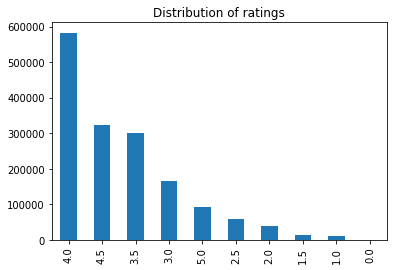

In [205]:
# Distribution of reviews

df.review_overall.value_counts().plot(kind="bar", title="Distribution of ratings")

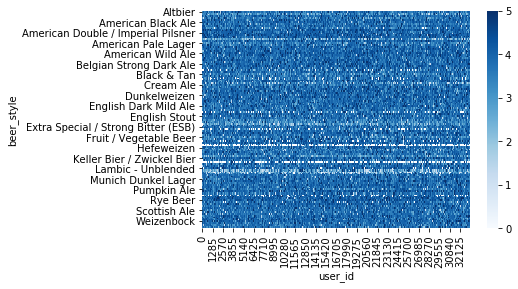

In [206]:
# Heatmap showing the distribution of ratings.

sns.heatmap(df.pivot_table('review_overall', index='beer_style', columns='user_id'), cmap="Blues")

## Feature Engineering

There are some items and users that might lead to noisy data. For example: Beers that have been rated only once or less and users who have not reviewed more than once. During matrix factorization, such data might lead to very sparse matrices thus increasing the computing time and resources. Let us filter them out.

In [207]:
# Remove users who have not reviewed more than once
df = df.groupby('user_id').filter(lambda x: len(x) > 1)

# remove beers that have been rated 
df = df.groupby('beer_beerid').filter(lambda x: len(x) > 1)

The ratings are distributed between 0 to 5. Let us center the rating around zero so that the distribution looks more symmetric.

In [208]:
review_cols = ['review_overall', 'review_aroma', 'review_appearance', 'review_palate', 'review_taste']

for col in review_cols:
    avg_rating = (df[col].max() + df[col].min()) / 2
    test[col] = df[col] - avg_rating

## Train/Test split

In [209]:
train_len = int(df.shape[0] * 0.8)
train = df[:train_len]
test = df[train_len:]

In [210]:
train['beer_beerid'].tail()

1268903    1902
1268904    1902
1268905    1902
1268906    1902
1268907    1902
Name: beer_beerid, dtype: int64

In [211]:
test['beer_beerid'].head()

1268908    1902
1268909    1902
1268910    1902
1268911    1902
1268912    1902
Name: beer_beerid, dtype: int64

In [212]:
# Duplicate entries with user_id, beer_beerid combination

df[df[['user_id', 'beer_beerid']].duplicated() == True][['user_id', 'beer_beerid']]

,user_id,beer_beerid
199,14591,25414
426,14591,10784
862,19985,10785
885,10161,10785
1348,20103,436
...,...,...
1585278,16935,9510
1585753,740,22273
1585815,28384,12172
1586027,5036,25095


# Metrics

RMSE = $\sqrt{\frac{\sum(\hat y - y^{2})}n}$

We plan to go ahead with RMSE. The lesser the error, the more we are sure about how a user would rate a particular beer.


The rating is between 0 to 5. So in a worst case scenario, our RMSE will be 5 (Ex: We consistently predict a rating of 0 and the actual rating is 5 for all users). The best case scenario, it will be zero (our rating and the actual rating is the same).

In [213]:
def rmse(y_pred, y_true):
    return np.sqrt(np.mean(np.power(y_pred - y_true, 2)))

In [88]:
def evaluate(estimate_f):    
    ids_to_estimate = zip(test.user_id, test.beer_beerid)
    estimated = np.array([estimate_f(u,i) for (u,i) in ids_to_estimate])
    real = test.review_overall
    return rmse(estimated, real)

## General notations in order to understand Content-based and CF formulas

`U is the set of users in our domain. It's size is |U|
I is the set of items in out domain. It's size is |I|
I(u) is the set of items that user u has rated.
-I(u) is the complement of I(u) i.e., the set of items user u has not rated.
U(i) is the set of users that have rated item i.
-U(i) is the complement of U(i). It's the set of users who have not rated for item i.
S(u, i) is a function that measures the utility of item i for user u.`

### Goal of recommendation systems:

$i^{*} = argmax_{i\in-I(u)} S(u,i), \forall u \in U$

Recommendation system can be summarized as finding that item that the user has not seen (-I(u)) which optimizes the notion of utility (metric) S(u, i)

# Content-based filtering


Recommend based on user's rating history. For example, if you want to know what I thought about the beer "Sausa Weizen", you'd look up my past ratings for all other beers, or may be for beers of that particular category or a group of categories and then come up with what you think would be my prediction for that beer.

For a baseline model, in order to predict the rating of a particular item ${i^{'}}$, we will look up all the items that the user has rated $I(u)$, evaluate the aggregation function, which in our case for the baseline model is the 'mean' and predict this value as the rating a user might give for any new beer. Not very intutive, but makes for a good baseline model.

$r_{u, i} = aggr_{i'\in I(u)}[r_{u, i'}]$

A simple example using mean as an aggregation function:

$r_{u,i} = \bar r_u = \frac {\sum_{i'\in I(u)} r_{u, i'}} {|I(u)|}$

In [89]:
# # Simple Content based filtering using mean ratings (baseline model)

def content_mean(user_id, beer_id):    
    user_condition = train.user_id == user_id
    ratings_by_user = train.loc[user_condition]
    
    return ratings_by_user.review_overall.mean()

print(f'RMSE for content based filtering: {evaluate(content_mean)}')

RMSE for content based filtering: 0.7269122601676697


In [90]:
# Simple Content based filtering using mean ratings

def content_mean_with_default_rating(user_id, beer_id):    
    user_condition = train.user_id == user_id
    ratings_by_user = train.loc[user_condition]
    
    if ratings_by_user.empty:
        return 3.0
    else:
        return ratings_by_user.review_overall.mean()

print(f'RMSE for content based filtering with default mean: {evaluate(content_mean_with_default_rating)}')

RMSE for content based filtering with default mean: 0.7359312674816878


# Using users rating history

Recommend based on other user's rating histories. For example: If you want to know how I might rate a beer that I have not tried, you could guess by seeing the ratings of other people who have tried that beer. Presumably people who are similar to me.
Here, the rating is based on aggregating other people's ratings (u') for a particular item.

$r_{u', i} = aggr_{u' \in U(i)}[r_{u', i}]$

A simple example using mean as an aggregation function:

$r_{u,i} = \bar r_i = \frac {\sum_{u' \in U(i)}}{|U(i)|} [r_{u',i}]$

In [91]:
# Simple filtering using mean ratings

def mean_users_ratings(user_id, beer_id):
    user_condition = train.user_id != user_id
    item_condition = train.beer_id == beer_id
    ratings_by_others = train[user_condition & item_condition, 'review_overall'].mean()
    
    if ratings_by_others.empty:
        return 3.0
    else:
        ratings_by_others.review_overall.mean()
    
print(f'RMSE for filtering using users rating: {evaluate(content_mean)}')

RMSE for filtering using users rating: 0.7269122601676697


## Incorporating similarities in content-based filtering

So far we have been making predictions using a generic set of users and beers. Let us find out if our predictions improve if we incorporate similarities, for ex: predicting ratings based on similar users or similar beers.

A general aggregation function for content-based filtering that incorporates similarity:

$r_{u,i} = k \sum_{i^{'} \in I(u)} sim(i, i') \; r_{u, i^{'}}$

$ r_{u,i} = \bar r_u + k \sum_{u' \in U(i)} sim(u, u') \; (r_{u',i} - \bar r_u) $

Here, instead of calculating a simple average like before, a weighted average is calculated by the sim function over the user's ratings. As you can observe, the sim function is taking 2 items i and i', so it will compute a number between 0 and 1 in order to calculate the weighted average. 

$ k = \frac{1}{\sum_{u' \in U(i)} |sim(u,u')|} $

In case the similarity function does not return a value between 0 and 1, we want to make sure it is normalized and hence introducing a K, which is the normalizing factor

$\bar r_u$ is the average rating of user u:

$ \bar r_u = \frac{\sum_{i \in I(u)} r_{u,i}}{|I(u)|} $

Pearson correlation: Build content-based function using custom sim function. We are going to aggregate on the rating of other beers, for the same type, in order to obtain a recommendation for a particular beer, but that aggregation is going to be weighted and the weighting is going to be determined by the Pearson correlation similarity between the beer we want to estimate the rating and all the other ratings for the other beers of the same type. This will tell us if the beer in consideration might be considered by a particular user or not.

In [117]:
def pearson(s1, s2):
    """Take two pd.Series objects and return a pearson correlation."""
    s1_c = s1 - s1.mean()
    s2_c = s2 - s2.mean()
    return np.sum(s1_c * s2_c) / np.sqrt(np.sum(s1_c ** 2) * np.sum(s2_c ** 2))

class ContentPearsonReco:
    """ Content based filtering using a custom sim(i,i'). """

    def learn(self):
        """ Prepare datastructures for estimation. """
        
        self.all_beer_profiles = df.pivot_table('review_overall', index='beer_beerid', columns='user_id')

    def estimate(self, user_id, beerid):
        """ Ratings weighted by correlation similarity. """
        
        user_condition = train.user_id == user_id

        ratings_by_user = train.loc[user_condition]
        if ratings_by_user.empty: 
            return 3.0
        
        ratings_by_user.set_index('beer_beerid', inplace=True)
        
        beer_ids = ratings_by_user.index
        beer_ratings = ratings_by_user.review_overall
        
        # Filter all beer profiles of the user
        print(user_id)
        print(self.all_beer_profiles.head())
        all_beer_profiles = self.all_beer_profiles[user_id]
        beer_profile = self.all_beer_profiles[user_id][beerid]
        
        weighted_similarities = all_beer_profiles.apply(lambda profile: pearson(profile, beer_profile))
        
        ratings_similarities = pd.DataFrame({'sim': similarities, 'rating': beer_ratings})
        ratings_similarities = ratings_sims[ratings_sims.sim > 0]
        if ratings_sims.empty:
            return their_ratings.mean()
        else:
            return np.average(ratings_sims.rating, weights=ratings_sims.sim)
        
reco = ContentPearsonReco()
reco.learn()
print(f'RMSE for ContentPearsonReco: {evaluate(reco.estimate)}')

ValueError: Unstacked DataFrame is too big, causing int32 overflow

**Questions:** 

1) Cold-start - what if there are no previous ratings by the user? Is it ok to assume the rating is 0 or 3? <br />
2) Is it a good idea to delete all users who have not rated at all or those who have not rated more than once? Similarly, is it a good idea to delete all beers not rated or rated by more than one user? Because, in both the above cases, there are chances that user_id/beer_id might appear only in either train or test datasets. I tested by removing both, but RMSE increased from 0.72691226 to 0.72698229 <br />
3) Any tips to speed this up? It takes a lot of time to run. <br />
4) How to deal with imbalanced data in recommendation systems? For instance, only a subset of the users would have reviewed most of the beers.


References:

https://towardsdatascience.com/evaluation-metrics-for-recommender-systems-df56c6611093 <br />
https://unatainc.github.io/pycon2015/
https://rstudio-pubs-static.s3.amazonaws.com/191386_f750ed5a99f1417da351f86b6d8b87ab.html